# OFDM Fundamentals

## Key Points:

1. Multi-carrier modulation: OFDM divides a high-rate data stream into multiple low-rate substreams distributed over orthogonal carriers.
2. Orthogonal signals: In OFDM, sub-carriers are spaced at intervals delta_f = 1/T, where T is the symbol duration

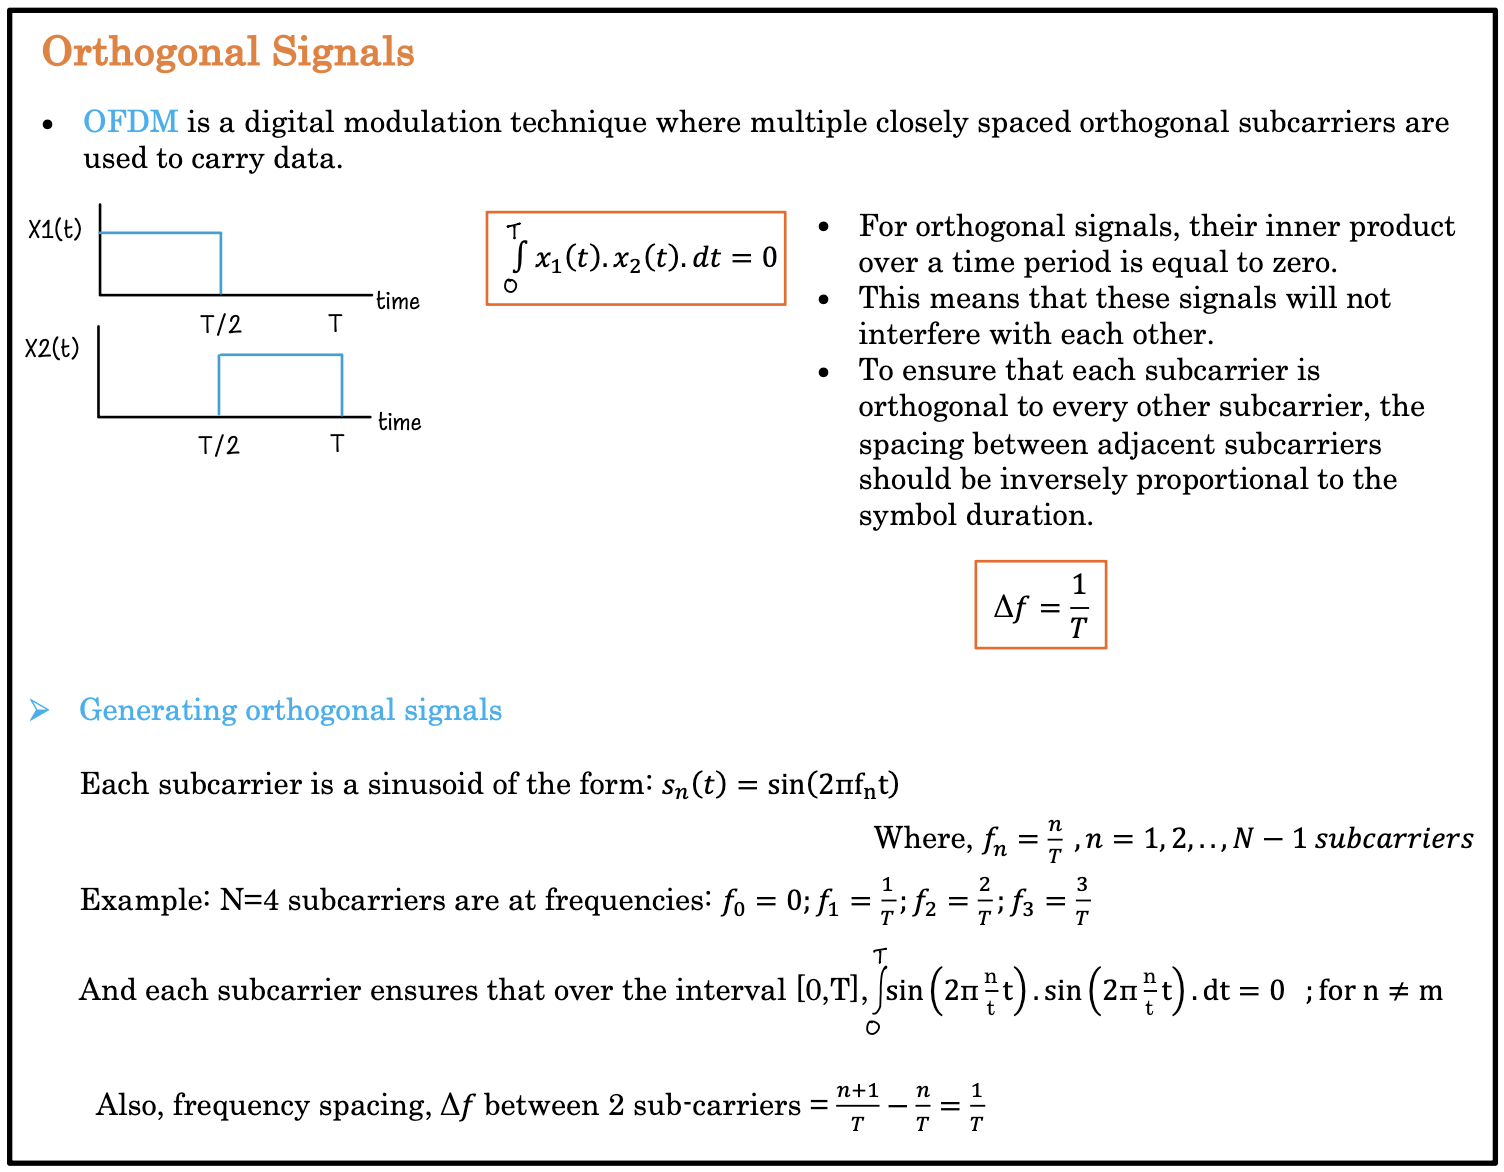

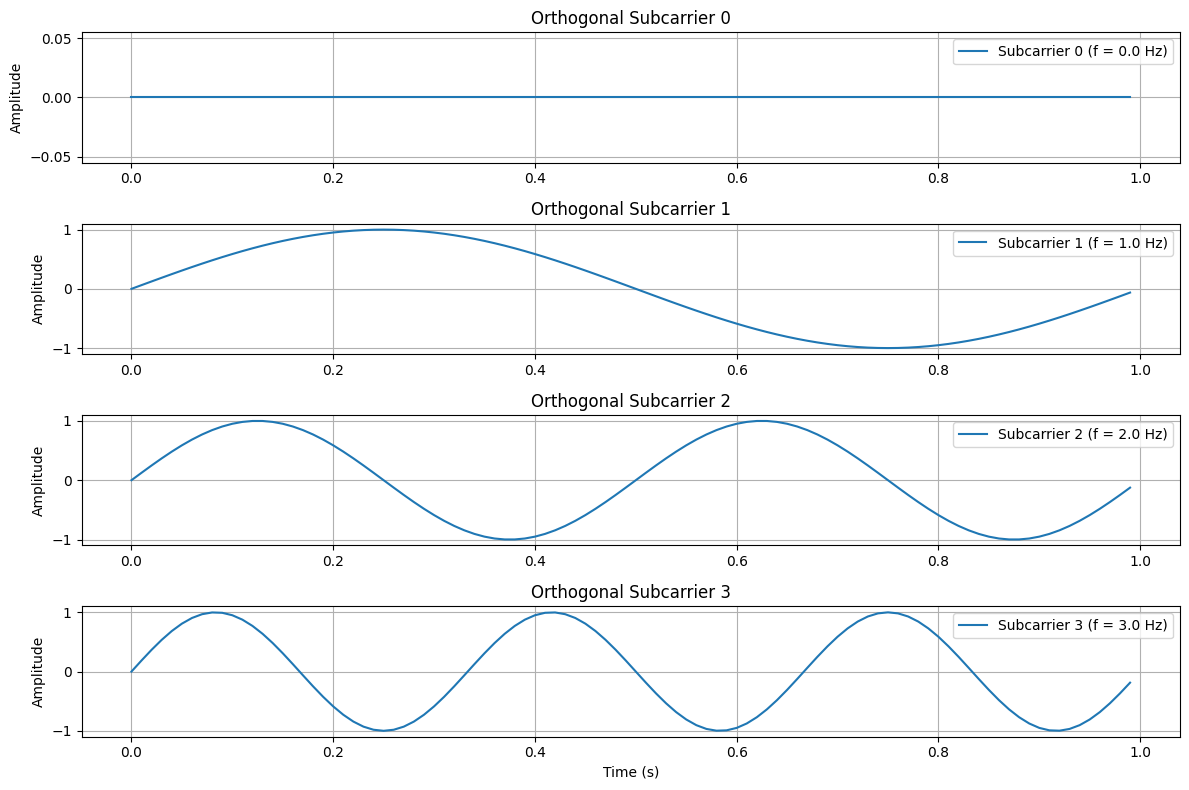

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1  # symbol duration (seconds)
N = 4  # number of subcarriers
fs = 100  # sampling frequency
t = np.linspace(0, T, int(T * fs), endpoint=False)

# Generate orthogonal subcarriers
subcarriers = [np.sin(2 * np.pi * n / T * t) for n in range(N)]

# Plot the subcarriers
plt.figure(figsize=(12, 8))
for i, carrier in enumerate(subcarriers):
    plt.subplot(N, 1, i + 1)
    plt.plot(t, carrier, label=f'Subcarrier {i} (f = {i/T:.1f} Hz)')
    plt.title(f'Orthogonal Subcarrier {i}')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()


* After learning about the orthogonal signals, lets diev into OFDM 

# OFDM Model


                                Input Data → Modulation (QAM/PSK) → Serial to Parallel → IFFT → Add Cyclic Prefix
                                                                       ↓

                                                Channel (with multipath fading and noise)
                                                                       ↓

                                Output Data ← Demodulation ← Parallel to Serial ← FFT ← Remove Cyclic Prefix

## Importing packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import helper_function


## Step-1: Input Data

I will try to transmit this elephant picture over the OFDM scheme to investigate various parameters of OFDM model.

In [3]:
# Load the image
img_path = "/home/rg9828/Documents/Blogger/Cellular_Modem/Cellular_Modem/pexels-tian-2499271.jpg"
img = Image.open(img_path).convert('L')  # Convert to grayscale
img_width = 128
img_height = 128
img = img.resize((img_width, img_height))  # Resize for simplicity
img_array = np.array(img)

# Convert image to binary
binary_data = np.unpackbits(np.array(img_array, dtype=np.uint8))
print(f"Binary data length: {len(binary_data)} bits")

Binary data length: 131072 bits


For simplicity, Total binary data length:

- 128 × 128 pixels
- Each pixel = 8 bits (grayscale, 1 byte)
- So, 128 × 128 × 8 = 131,072 bits

## Step-2: Modulating binary data

Symbols generated size:  (32768,) 



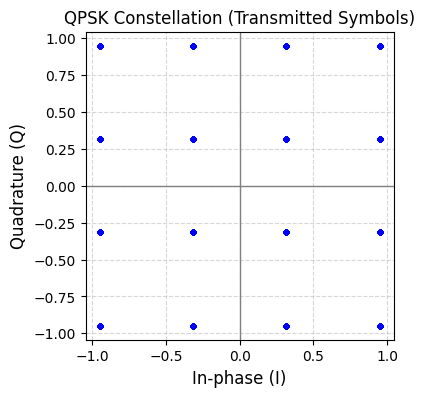

In [4]:
from scipy import signal

# Let's start by transmitting our data using QPSK modulation scheme (2 bits/symbol).
mod_scheme = '16-QAM'
mod_config = helper_function.get_modulation_config(mod_scheme)
if not mod_config:
    raise ValueError(f"Unsupported modulation scheme: {mod_scheme}")

bits_per_symbol = mod_config['bits_per_symbol']

# Group bits into symbols (QPSK: 2 bits per symbol)
num_symbols = len(binary_data) // bits_per_symbol

# Generate symbols
symbols = helper_function.symbols_gen(num_symbols, mod_scheme)  # Using the helper function
print("Symbols generated size: ", symbols.shape, "\n")

# Plot constellation
helper_function.scatterplot(np.real(symbols), np.imag(symbols))
plt.title("QPSK Constellation (Transmitted Symbols)")
plt.show()

## Step-3: OFDM Modulation

- OFDM Symbol Duration (N = 64 samples)
- The CP is typically a fraction of the OFDM symbol length (e.g., 1/4, 1/8, 1/16).
- Here, CP = 16 means 25% of the symbol length (16/64 = 0.25), which is a common choice (similar to LTE, where CP is ~7% for short symbols and ~25% for long symbols).

Symbols shape after padding:  (32768,) 

OFDM blocks size:  (512, 64) 

Time-domain blocks size:  (512, 64) 

Time-domain blocks size after adding CP:  (512, 80) 

Transmitted signal size after flattening:  (40960,) 



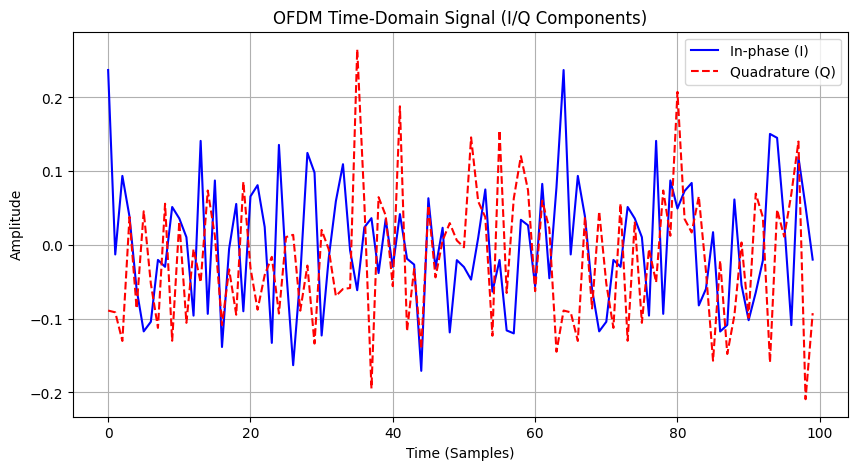

In [5]:
# OFDM parameters
N = 64      # Number of sub-carriers
CP = 16     # Cyclic Prefix length


# Pad symbols to fit OFDM blocks
# Before processing, the input symbols must be divided into blocks of size N = 64, i.e., number of subcarriers.
# Therefore, if its not perfectly divisible by N, we need zero-padding to make it fit.
if len(symbols) % N != 0:
    symbols = np.concatenate([symbols, np.zeros(N - len(symbols) % N)])
print("Symbols shape after padding: ", symbols.shape, "\n")


# Reshape into OFDM blocks
ofdm_blocks = symbols.reshape(-1,N)
print("OFDM blocks size: ", ofdm_blocks.shape, "\n")


# IFFT to convert to time domain
time_blocks = np.fft.ifft(ofdm_blocks, axis=1)
print("Time-domain blocks size: ", time_blocks.shape, "\n")


# Add cyclic prefix
# Take the last 16 samples (CP=16) of each symbol and prepends them.
time_blocks_cp = np.concatenate([time_blocks[:, -CP:], time_blocks], axis=1)
print("Time-domain blocks size after adding CP: ", time_blocks_cp.shape, "\n")


# Flatten for transmission
tx_signal = time_blocks_cp.flatten()
print("Transmitted signal size after flattening: ", tx_signal.shape, "\n")


# Plot time-domain signal
helper_function.plot_complex_signal(tx_signal[0:100])  # First 1000 samples
plt.title("OFDM Time-Domain Signal (I/Q Components)")
plt.show()

## Step-4: Simulate Channel (AWGN + Multipath)

- [TX Signal] → [AWGN] → [Multipath Channel] → [RX Signal]
-                  ↑               ↑
-             20 dB SNR      Main + 30% echo

Received signal block size after adding AWGN:  (40960,) 

Received signal block size after adding Multipath:  (40960,) 



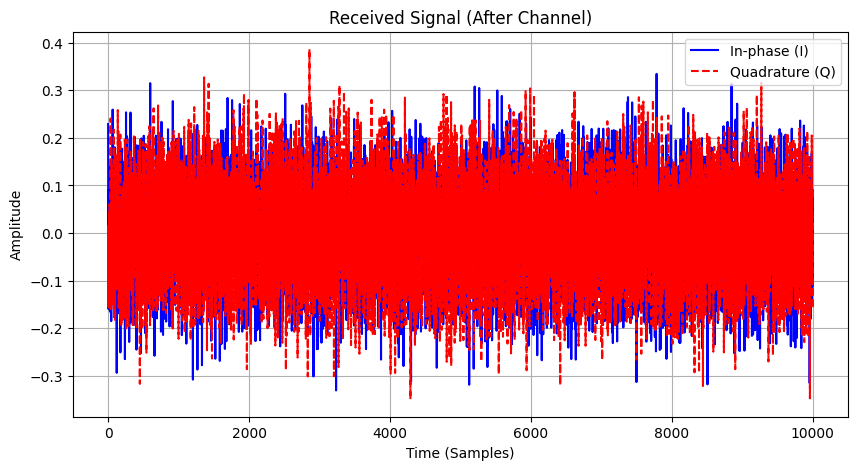

In [ ]:
# Add AWGN (SNR = 20 dB: A relatively clean channel)
# add_awgn()
    # 1. Measures the original signal power: P_signal = mean(|tx_signal|²)
    # 2. Calculates required noise power: P_noise = P_signal / 10^(SNR/10)
    # 3. Generates complex Gaussian noise with this power
    # 4. Adds it to the transmitted signal
snr_db = 20
rx_signal = helper_function.add_awgn(tx_signal, snr_db)  # Using your helper function
print("Received signal block size after adding AWGN: ", rx_signal.shape, "\n")  # Size = 2048 x 80 = 163,840


# Simulate multipath channel (simple 2-tap model)
    # First tap (1.0): Direct line-of-sight path (strongest)
    # Second tap (0.3): Delayed reflection (30% amplitude of main path)
channel_taps = np.array([1.0, 0.3])  # Direct path + echo
rx_signal = np.convolve(rx_signal, channel_taps, mode='same')
print("Received signal block size after adding Multipath: ", rx_signal.shape, "\n")


# Plot received signal
helper_function.plot_complex_signal(rx_signal[0:100])
plt.title("Received Signal (After Channel)")
plt.show()

## Step 5: OFDM Demodulation

Received signal block size:  (512, 80) 

Received signal block size after removing CP:  (512, 64) 

Received signal block size after converting back to frequency domain:  (512, 64) 

Received signal block size after equalizing:  (32768,) 



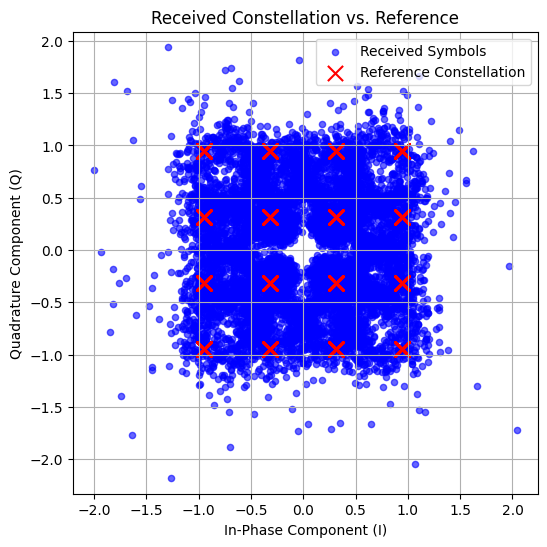

In [10]:
# Reshape into blocks
rx_blocks = rx_signal.reshape(-1, N + CP)
print("Received signal block size: ", rx_blocks.shape, "\n")


# Remove cyclic prefix
rx_blocks = rx_blocks[:, CP:]
print("Received signal block size after removing CP: ", rx_blocks.shape, "\n")


# FFT to convert back to frequency domain
rx_symbols_blocks = np.fft.fft(rx_blocks, axis=1)
print("Received signal block size after converting back to frequency domain: ", rx_symbols_blocks.shape, "\n")


# Flatten and equalize (simple zero-forcing)
rx_symbols = rx_symbols_blocks.flatten()
# H_est = 1.0  # Assume perfect channel estimation (for simplicity)

# Estimate channel frequency response
pilot_symbols = ofdm_blocks[:, 0]  # Use first subcarrier as pilot
received_pilots = rx_symbols_blocks[:, 0]
H_est = received_pilots / pilot_symbols

# Apply frequency-domain equalization
rx_symbols_eq = rx_symbols_blocks / H_est[:, np.newaxis]
rx_symbols_eq = rx_symbols_eq.flatten()
print("Received signal block size after equalizing: ", rx_symbols_eq.shape, "\n")


# Plot constellation (before/after equalization)
helper_function.plot_constellation(rx_symbols_eq[:10000], symbols[:10000])
plt.title("Received Constellation vs. Reference")
plt.show()

## Step 6: Demodulate & Reconstruct Image

BER: 4.38e-01


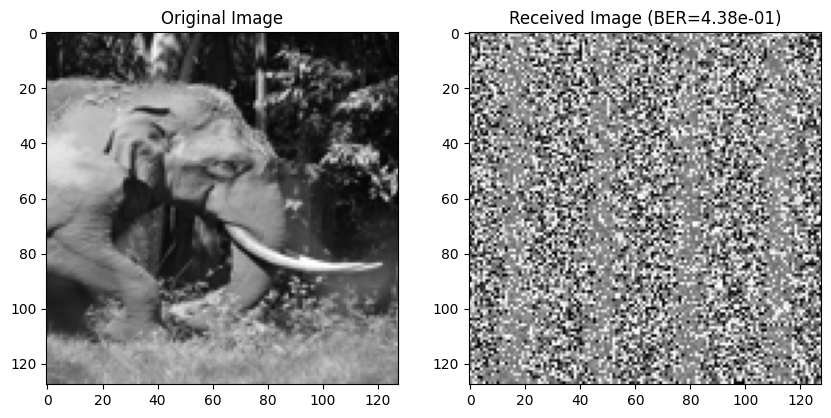

In [9]:
# Use the correct constellation reference
constellation = helper_function.symbols_gen(bits_per_symbol, mod_scheme)  # All 16-QAM points
rx_bits = helper_function.demodulate_symbols(rx_symbols_eq[:num_symbols], mod_scheme)

# # 1. Get original parameters
original_bit_length = len(binary_data)  # 131072

# # 2. Demodulate received signal
# rx_bits = helper_function.demodulate_symbols(rx_symbols_eq, mod_scheme)[:original_bit_length]

# 3. BIT-LEVEL RECONSTRUCTION
# Ensure exact bit length match
rx_bits = rx_bits[:original_bit_length]
rx_img_array = np.packbits(rx_bits).reshape(img_height, img_width)


# 4. Calculate BER using original TX symbols (not the padded OFDM signal)
tx_symbols_original = helper_function.symbols_gen(original_bit_length // bits_per_symbol, mod_scheme)
tx_bits_original = helper_function.demodulate_symbols(tx_symbols_original, mod_scheme)
ber = np.mean(rx_bits != tx_bits_original)

print(f"BER: {ber:.2e}")

# 5. Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array, cmap='gray')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(rx_img_array, cmap='gray')
plt.title(f"Received Image (BER={ber:.2e})")
plt.show()